In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# MOdel selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression

# Model hyper parameter tuning
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score,roc_curve

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os


import warnings  
warnings.filterwarnings('ignore')
from sklearn.neighbors import LocalOutlierFactor

In [2]:
def read_file(folder, samp = False, lof=False):
    df = pd.read_csv(folder)
    if samp==True:
        df = df.sample(frac=0.5, replace=False, random_state=42).reset_index(drop=True)
    if lof==True:
        #df_new = pd.DataFrame(scaler.fit_transform(df_new))
        df = filter_lof(df)
        #df_new = scaler.inverse_transform(df_new)
    return df

In [3]:
def filter_lof(df, k=20) :
    lof = LocalOutlierFactor(n_neighbors=k)
    scaler = StandardScaler()
    df2 = pd.DataFrame.copy(df)
    df2 = df2.drop(columns = ['churn'])
    df2 = pd.DataFrame(scaler.fit_transform(df2))
    df2["_lof"] = lof.fit_predict(df2)
    df2 = df2[df2["_lof"]>0].drop(columns="_lof")#.reset_index(drop=True)
    df2 = pd.DataFrame(scaler.inverse_transform(df2))
    df2['churn'] = df['churn']
    return df2.reset_index(drop=True)

In [16]:
def churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    #print (algorithm)
    #print ("\n Classification report : \n",classification_report(testing_y,predictions))
    #print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    return accuracy_score(testing_y,predictions)
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)


In [4]:
def train_model(filename, algo, seed, before) :
    X, Y = readXY(filename, before)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    rfe_algo = algo
    
    accuracy = churn_prediction(rfe_algo, x_train, x_test, y_train, y_test, x_train.columns,"features",threshold_plot = False)
    return rfe_algo, accuracy

In [22]:
def readXY(filename,before) :
    df = read_file(filename, samp=False, lof=False)
    if before == True:
        data_churn = df.drop(['churn'],axis = 1)
        df = churn(df)
    else:
        df['churn'] = df.apply(is_churned, axis=1)
    df = df.dropna().reset_index(drop=True)
    X = df.drop(columns=['churn'], axis=1)
    Y = df[['churn']]
    return X, Y

In [19]:
def churn_validation(algorithm,testing_x,
                             testing_y,cols) :
    #model
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    #print (algorithm)
    #print ("\n Classification report : \n",classification_report(testing_y,predictions))
    #print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    return accuracy_score(testing_y,predictions)

In [18]:
def validate_with_raw_data(model, before) :
    X, Y = readXY('/data/dataprivacy/churn/telecom_churn_data_pre_nodates.csv', before)
    acc = churn_validation(model, X,Y, X.columns)
    return acc

# churn label anonymized

In [6]:
df = pd.read_csv('/data/dataprivacy/churn-anonymized/v1/alex2/k10_e10_lof/telecom_churn_data_pre_nodates.csv')

In [16]:
len(df[df['churn']<0.5])/len(df)

0.9093596432496621

In [13]:
data = pd.read_csv('/data/dataprivacy/churn/telecom_churn_data_pre_nodates.csv')

In [17]:
len(data[data['churn']<0.5])/len(data)

0.8980889808898089

# churn label created after 

In [17]:
def is_churned(_x):
    if ((_x.total_ic_mou_9 == 0) & (_x.total_og_mou_9 == 0) & (_x.vol_2g_mb_9 == 0) & (_x.vol_3g_mb_9 == 0)):
        return 1
    else:
        return 0

In [26]:
data_churn = df.drop(['churn'],axis = 1)
data_churn['churn'] = data_churn.apply(is_churned, axis=1)

In [27]:
len(data_churn[data_churn['churn']<0.5])/len(data_churn)

0.9252896069935194

In [9]:
def churn(df, before=True):
    if before == True:
        df.loc[df['churn'] > 0.5, 'churn'] = 1
        df.loc[df['churn'] <= 0.5, 'churn'] = 0
    return df

In [14]:
algos = [RandomForestClassifier(n_jobs=-1,
                                bootstrap=True,
                                max_depth=10,
                                min_samples_leaf=50,
                                min_samples_split=50,
                                n_estimators=60)]

In [23]:
df_eval = pd.DataFrame(columns = ['accuracy'])
before = True

for algo_anon in ['attila1', 'attila2', 'alex1b', 'alex2']:
    print(algo_anon)
    if algo_anon=='alex1b' or 'alex2':
        df_original = read_file('/data/dataprivacy/churn/telecom_churn_data_pre_nodates.csv', lof=True)
        df_original = df_original.dropna().reset_index(drop=True)
    if algo_anon=='attila1' or 'attila2':
        df_original = read_file('/data/dataprivacy/churn/telecom_churn_data_pre_nodates.csv')
    for file in os.listdir('/data/dataprivacy/churn-anonymized/v1/'+algo_anon):
        if file.startswith('c') or file.startswith('k'):
            print(file)
            #file beolvasas
            folder = '/data/dataprivacy/churn-anonymized/v1/'+algo_anon+'/'+file+'/'+'telecom_churn_data_pre_nodates.csv'
            #df = read_file(folder)
            #df = df.dropna().reset_index(drop=True)
            ultim_best_scores = 0
            df_ultim_best = pd.DataFrame()
            for seed in [0,1,2,3]:
                print(seed)
                ultim_best_scores = 0
                df_ultim_best = pd.DataFrame()
                for algo in algos:
                    #print(algo)
                    model, accuracy_train =  train_model(folder, algo, seed, before=True)
                    if accuracy_train > ultim_best_scores:
                        ultim_best_scores = accuracy_train
                        best_model = model 
    
                    ###
                df_eval.loc[algo_anon+'_'+file+'_'+str(seed)] = ultim_best_scores
                df_eval.loc[algo_anon+'_'+file+'_'+str(seed)+'_original'] = validate_with_raw_data(best_model,before=True)
                df_eval.to_csv('churn_eval_total_class_attila.csv')

attila1
c3_e1
0
1
2
3
c20_e10
0
1
2
3
c10_e1
0
1
2
3
c3_e10
0
1
2
3
c10_e10
0
1
2
3
c5_e10
0
1
2
3
c5_e1
0
1
2
3
c20_e1
0
1
2
3
attila2
c3_e1
0
1
2
3
c20_e10
0
1
2
3
c10_e1
0
1
2
3
c3_e10
0
1
2
3
c10_e10
0
1
2
3
c5_e10
0
1
2
3
c5_e1
0
1
2
3
c20_e1
0
1
2
3
alex1b


KeyboardInterrupt: 

# churn label created after anonymization

In [25]:
df_eval = pd.DataFrame(columns = ['accuracy'])
before = False

for algo_anon in ['attila1', 'attila2', 'alex1b', 'alex2']:
    print(algo_anon)
    if algo_anon=='alex1b' or 'alex2':
        df_original = read_file('/data/dataprivacy/churn/telecom_churn_data_pre_nodates.csv', lof=True)
        df_original = df_original.dropna().reset_index(drop=True)
    if algo_anon=='attila1' or 'attila2':
        df_original = read_file('/data/dataprivacy/churn/telecom_churn_data_pre_nodates.csv')
    for file in os.listdir('/data/dataprivacy/churn-anonymized/v1/'+algo_anon):
        if file.startswith('c') or file.startswith('k'):
            print(file)
            #file beolvasas
            if before == True:
                folder = '/data/dataprivacy/churn-anonymized/v1/'+algo_anon+'/'+file+'/'+'telecom_churn_data_pre_nodates.csv'
            else:
                folder = '/data/dataprivacy/churn-anonymized/v2-nochurn/'+algo_anon+'/'+file+'/'+'telecom_churn_data_pre_nodates_nochurn.csv'
            #df = read_file(folder)
            #df = df.dropna().reset_index(drop=True)
            ultim_best_scores = 0
            df_ultim_best = pd.DataFrame()
            for seed in [0,1,2,3]:
                print(seed)
                ultim_best_scores = 0
                df_ultim_best = pd.DataFrame()
                for algo in algos:
                    #print(algo)
                    model, accuracy_train =  train_model(folder, algo, seed, before)
                    if accuracy_train > ultim_best_scores:
                        ultim_best_scores = accuracy_train
                        best_model = model 
    
                    ###
                df_eval.loc[algo_anon+'_'+file+'_'+str(seed)] = ultim_best_scores
                df_eval.loc[algo_anon+'_'+file+'_'+str(seed)+'_original'] = validate_with_raw_data(best_model,before = True)
                df_eval.to_csv('churn_eval_total_class_after.csv')

attila1
c3_e1
0
1
2
3
c20_e10
0
1
2
3
c10_e1
0
1
2
3
c3_e10
0
1
2
3
c10_e10
0
1
2
3
c5_e10
0
1
2
3
c5_e1
0
1
2
3
c20_e1
0
1
2
3
attila2
c3_e1
0
1
2
3
c20_e10
0
1
2
3
c10_e1
0
1
2
3
c3_e10
0
1
2
3
c10_e10
0
1
2
3
c5_e10
0
1
2
3
c5_e1
0
1
2
3
c20_e1
0
1
2
3
alex1b
k10_e10_lof
0
1
2
3
k10_e1_lof
0
1
2
3
k20_e5_lof
0
1
2
3
k20_e1_lof
0
1
2
3
k50_e5_lof
0
1
2
3
k50_e1_lof
0
1
2
3
k20_e10_lof
0
1
2
3
k10_e5_lof
0
1
2
3
k50_e10_lof
0
1
2
3
alex2
k10_e10_lof
0
1
2
3
k10_e1_lof
0
1
2
3
k20_e5_lof
0
1
2
3
k20_e1_lof
0
1
2
3
k50_e5_lof
0
1
2
3
k50_e1_lof
0
1
2
3
k20_e10_lof
0
1
2
3
k10_e5_lof
0
1
2
3
k50_e10_lof
0
1
2
3


In [91]:
folder = '/data/dataprivacy/churn-anonymized/v2-nochurn/'+'alex2'+'/'+'k10_e1_lof'+'/'+'telecom_churn_data_pre_nodates_nochurn.csv'
#X,Y = readXY(folder,before=False)
df_v2 = pd.read_csv(folder)

In [110]:
df_v2[abs(df_v2['total_ic_mou_9'])<30] and 

SyntaxError: invalid syntax (<ipython-input-110-ae5c79a33d8d>, line 1)

In [114]:
df_v2.mean(axis=0)

circle_id          109.000000
loc_og_t2o_mou       0.000000
std_og_t2o_mou       0.000000
loc_ic_t2o_mou       0.000000
arpu_6             223.495274
                     ...     
aon               1190.005447
aug_vbc_3g          42.896684
jul_vbc_3g          43.364167
jun_vbc_3g          38.649296
sep_vbc_3g           1.404142
Length: 213, dtype: float64

In [118]:
df_v2.columns.get_loc('vol_3g_mb_9')

175

In [126]:
df_v2

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,109.0,0.0,0.0,0.0,181.220853,2.659429e+02,62.803864,-101.707173,3.743522e-02,-0.176720,...,1.387779e-17,1.000000e+00,1.000000,-4.599767e-01,1.469210e-01,-905.528974,-642.527466,2.542945e+02,-330.405956,5.145668e+00
1,109.0,0.0,0.0,0.0,194.445576,2.950611e+02,615.345395,357.762482,4.397657e+01,-170.931242,...,1.387779e-17,-4.157570e-01,1.000000,-3.316233e+00,-5.551115e-17,2832.208702,175.658969,2.815906e+01,-4.747591,4.440892e-16
2,109.0,0.0,0.0,0.0,107.203018,-1.043132e+02,96.593478,57.575375,1.733541e+02,334.479593,...,1.387779e-17,8.326673e-17,0.000000,-2.775558e-17,-5.551115e-17,1807.917918,0.000000,-1.421085e-14,0.000000,4.440892e-16
3,109.0,0.0,0.0,0.0,84.212483,1.377966e+02,-26.575590,690.576735,1.906475e+02,-0.422661,...,1.387779e-17,8.326673e-17,0.000000,-2.775558e-17,-5.551115e-17,1744.764285,0.000000,-1.421085e-14,0.000000,4.440892e-16
4,109.0,0.0,0.0,0.0,766.880977,9.303049e+01,122.506354,-168.726781,7.338056e+02,369.759637,...,1.387779e-17,8.326673e-17,0.172028,-2.775558e-17,-5.551115e-17,1171.800625,0.000000,-1.330618e+01,-237.540365,4.440892e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78930,109.0,0.0,0.0,0.0,138.987243,5.803306e+02,-31.396519,385.397459,-1.905616e+02,-265.222448,...,1.387779e-17,8.326673e-17,0.000000,-2.775558e-17,-5.551115e-17,4169.074050,0.000000,-1.421085e-14,0.000000,4.440892e-16
78931,109.0,0.0,0.0,0.0,17.065797,5.684342e-14,86.607137,0.000000,-1.421085e-14,0.000000,...,1.387779e-17,8.326673e-17,0.000000,-2.775558e-17,-5.551115e-17,1038.973898,0.519699,-1.421085e-14,0.000000,4.440892e-16
78932,109.0,0.0,0.0,0.0,-8.725932,-4.539808e+01,92.239463,49.708904,3.139659e+01,66.994656,...,1.387779e-17,8.326673e-17,0.000000,-2.775558e-17,-5.551115e-17,2744.285254,0.000000,-1.421085e-14,0.000000,4.440892e-16
78933,109.0,0.0,0.0,0.0,174.294564,1.015983e+02,-34.152693,48.531548,1.372114e+02,-27.603571,...,1.387779e-17,8.326673e-17,0.000000,-2.775558e-17,-5.551115e-17,1140.945592,0.000000,-1.421085e-14,0.000000,4.440892e-16


In [146]:
X

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,109.0,0.0,0.0,0.0,619.053217,519.803080,-611.476203,-226.130305,663.847410,123.035207,...,1.018184e+00,1.637737e+00,1.000000e+00,1.103814e+00,6.272771e-02,813.720588,1.142886e+03,466.445467,-431.014128,1.110930e+02
1,109.0,0.0,0.0,0.0,848.538261,55.293766,12.520556,-759.579208,31.263356,-45.653915,...,1.387779e-17,-1.011325e+00,1.549136e-01,1.000000e+00,1.170454e+00,-5548.301640,1.455689e+03,135.988733,2.324995,6.392779e+01
2,109.0,0.0,0.0,0.0,1875.267950,18.114829,1377.265640,550.371678,-119.519232,-27.205765,...,1.387779e-17,8.326673e-17,0.000000e+00,2.775558e-17,0.000000e+00,9039.785885,1.384179e+01,6.756442,-249.630131,4.491787e+01
3,109.0,0.0,0.0,0.0,-56.719459,1370.167870,2052.098653,397.161507,-245.721264,57.526657,...,-7.007637e-01,7.334009e-01,2.449337e+00,-6.174560e-01,3.068920e-01,8066.833900,-2.743970e+02,1200.884430,577.447909,1.189365e+02
4,109.0,0.0,0.0,0.0,-353.848956,7793.440082,345.226660,-35.965024,4.763104,1378.529403,...,-5.050396e+00,6.031384e-01,1.680941e-01,-1.405304e+00,6.491976e-01,1284.355716,2.850114e+03,7260.046819,226.417589,3.158261e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78930,109.0,0.0,0.0,0.0,1044.744482,-76.565742,837.372018,-171.071691,1287.210199,632.738364,...,1.122652e+00,1.110223e-16,2.207608e-01,1.655661e+00,-2.136944e-01,1515.464668,-3.120130e+01,267.710444,-158.088630,-1.154937e+01
78931,109.0,0.0,0.0,0.0,23.338848,157.629914,112.804541,1184.506407,3.140131,0.000000,...,1.387779e-17,8.326673e-17,0.000000e+00,2.775558e-17,0.000000e+00,950.448512,-1.640405e+02,-85.007805,0.000000,0.000000e+00
78932,109.0,0.0,0.0,0.0,-84.081785,268.648562,216.937918,183.648925,-45.874152,-48.898012,...,1.387779e-17,1.110223e-16,5.551115e-17,5.551115e-17,-5.551115e-17,454.158898,-1.421085e-14,-0.004732,8.626007,1.332268e-15
78933,109.0,0.0,0.0,0.0,382.300143,-133.898142,521.163895,-92.283961,-395.291389,-212.135451,...,1.387779e-17,-7.824352e-02,5.551115e-17,1.061994e+00,-5.551115e-17,2632.010832,-2.951044e+02,-1828.181105,969.992779,1.269836e+02


In [ ]:
indexes = X.loc[( X['total_og_mou_9']<0.5) & (X['total_ic_mou_9']<0.3) & (X['vol_2g_mb_9'] < 0.3) & (X['vol_3g_mb_9'] < 1)].index.tolist()

In [156]:
len(indexes)

7590

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee4df18490>]],
      dtype=object)

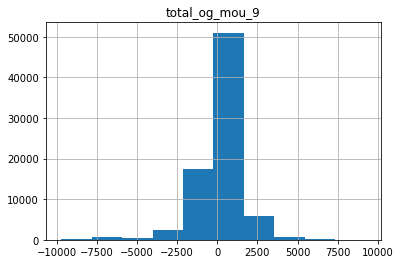

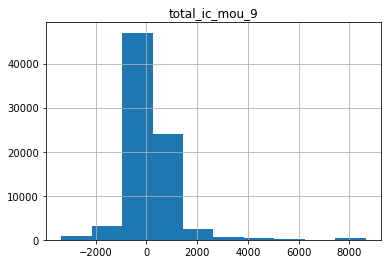

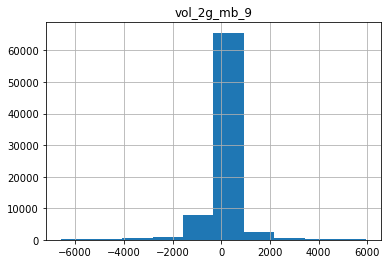

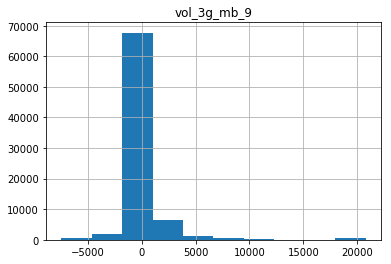

In [160]:
X.hist(column = 'total_og_mou_9')
X.hist(column = 'total_ic_mou_9')
X.hist(column = 'vol_2g_mb_9')
X.hist(column = 'vol_3g_mb_9')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feed88345d0>]],
      dtype=object)

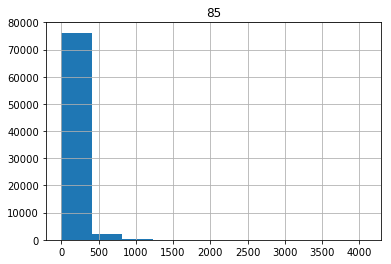

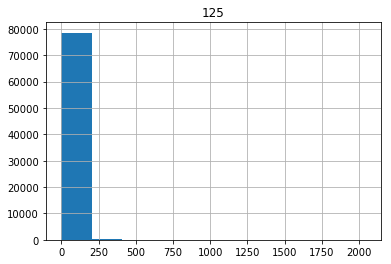

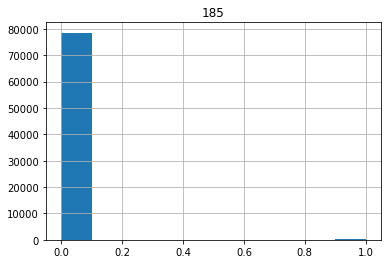

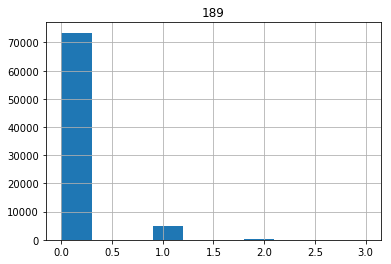

In [162]:
df.hist(column = 85)
df.hist(column = 125)
df.hist(column = 185)
df.hist(column = 189)

In [63]:
folder2 = '/data/dataprivacy/churn-anonymized/v1/'+'alex1b'+'/'+'k50_e1_lof'+'/'+'telecom_churn_data_pre_nodates.csv'
X2,Y2 = readXY(folder2,before=True)

In [64]:
X2['total_og_mou_9']

0        -922.879411
1        -386.505826
2         104.320786
3        -727.358739
4         497.045445
            ...     
79154    -987.915429
79155       0.000000
79156     193.808276
79157     113.181272
79158   -2325.439549
Name: total_og_mou_9, Length: 79159, dtype: float64

In [55]:
pd.read_csv('/data/dataprivacy/churn-anonymized/v1/'+'alex1b'+'/'+'k50_e1_lof'+'/'+'telecom_churn_data_pre_nodates.csv')

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,109.0,0.0,0.0,0.0,-2366.722143,402.400424,-1034.474218,-375.940677,635.430325,-2.593246e+01,...,1.043164e+00,1.000000e+00,4.120552e+00,-4.481822e-03,7409.535158,-407.220457,795.753480,-2.968815e+02,-2.010511e+02,2.191005e-01
1,109.0,0.0,0.0,0.0,801.404864,345.744968,189.103821,465.480280,56.978570,4.063591e+02,...,-8.463667e-01,1.447607e+00,3.591724e-01,2.017126e+00,9487.048133,92.598454,1528.365782,-5.215506e+02,3.260960e+02,-4.034922e-01
2,109.0,0.0,0.0,0.0,689.528011,1193.662575,258.331477,209.927813,13.694296,-1.228990e+02,...,1.110223e-16,5.551115e-17,2.775558e-17,-5.551115e-17,-2624.043482,-52.244362,-5.728545,2.709244e+01,2.411616e+01,4.163336e-17
3,109.0,0.0,0.0,0.0,1230.671368,-994.809980,-264.300937,-475.423997,-64.911989,9.064516e+02,...,-1.084632e+00,3.265501e-01,2.955935e-01,-5.100454e-01,-422.572206,-2975.751822,-14.249395,1.880285e+01,-3.863658e+01,-6.809544e-01
4,109.0,0.0,0.0,0.0,1987.517057,1305.324967,34.535791,1379.782674,548.730341,-9.573482e+01,...,9.902213e-01,7.754925e-02,7.539917e-01,3.706530e-01,-1013.681214,-884.672539,11796.198955,-1.574164e+03,-2.637962e+02,-2.746405e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79154,109.0,0.0,0.0,0.0,219.344703,680.246518,1273.620634,-328.160444,-1707.160772,-1.364931e+03,...,6.248468e-02,3.688569e-01,-2.486849e-01,2.925030e+00,-384.529941,-149.402526,113.378064,0.000000e+00,4.440892e-16,-1.889708e-01
79155,109.0,0.0,0.0,0.0,53.768643,-7.511500,-45.300774,8.679241,2.135669,-2.842171e-14,...,-2.775558e-17,-5.551115e-17,2.775558e-17,-5.551115e-17,-928.403222,-259.275372,-105.413035,-1.421085e-14,-8.881784e-16,1.000000e+00
79156,109.0,0.0,0.0,0.0,277.298940,-195.606692,8.107284,5.475105,75.567825,1.442172e+02,...,1.110223e-16,5.551115e-17,2.775558e-17,-8.326673e-17,-475.320890,0.182847,2.414095,4.956273e+01,9.735244e-01,4.163336e-17
79157,109.0,0.0,0.0,0.0,339.907329,49.975342,-132.682926,-255.916868,13.745715,-4.934918e+01,...,1.110223e-16,5.551115e-17,5.551115e-17,8.326673e-17,4237.061427,35.889986,89.626799,-5.312374e+00,2.664535e-15,4.163336e-17


In [140]:
Y2[Y2['churn']==1]

,churn
5,1.0
12,1.0
16,1.0
21,1.0
22,1.0
...,...
79122,1.0
79132,1.0
79138,1.0
79155,1.0


In [39]:
df = read_file('/data/dataprivacy/churn/telecom_churn_data_pre_nodates.csv', lof=True)

In [143]:
df

,0,1,2,3,4,5,6,7,8,9,...,204,205,206,207,208,209,210,211,212,churn
0,109.0,0.0,0.0,0.0,197.385,214.816,213.803,21.100,0.00,0.00,...,1.000000e+00,1.0,1.000000e+00,0.0,968.0,30.40,0.00,101.20,3.58,1
1,109.0,0.0,0.0,0.0,34.047,355.074,268.321,86.285,24.11,78.68,...,2.775558e-17,1.0,1.000000e+00,0.0,1006.0,0.00,0.00,0.00,0.00,0
2,109.0,0.0,0.0,0.0,261.636,309.876,238.174,163.426,50.31,149.44,...,2.775558e-17,0.0,2.775558e-17,0.0,1526.0,0.00,0.00,0.00,0.00,0
3,109.0,0.0,0.0,0.0,50.258,58.810,83.386,170.826,50.16,43.63,...,2.775558e-17,0.0,2.775558e-17,0.0,1471.0,0.00,0.00,0.00,0.00,0
4,109.0,0.0,0.0,0.0,429.023,190.704,255.114,114.751,71.03,45.03,...,2.775558e-17,0.0,2.775558e-17,0.0,1673.0,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78930,109.0,0.0,0.0,0.0,100.073,155.667,213.010,194.063,80.44,74.33,...,2.775558e-17,0.0,2.775558e-17,0.0,1168.0,0.00,0.00,0.00,0.00,0
78931,109.0,0.0,0.0,0.0,8.440,0.000,80.387,0.000,0.00,0.00,...,2.775558e-17,0.0,2.775558e-17,0.0,492.0,0.00,0.00,0.00,0.00,0
78932,109.0,0.0,0.0,0.0,18.471,69.161,57.530,29.950,5.40,3.36,...,2.775558e-17,0.0,2.775558e-17,0.0,3199.0,0.00,0.00,0.00,0.00,0
78933,109.0,0.0,0.0,0.0,112.201,77.811,79.081,140.835,29.26,18.13,...,2.775558e-17,0.0,2.775558e-17,0.0,2052.0,0.00,0.00,0.00,0.00,0


In [124]:
df.mean(axis=0)[175]

116.04503148159827

In [144]:
indexes_o = df[df['churn']==1].index.tolist()

In [150]:
len(set(indexes)&set(indexes_o))

770

In [142]:
len(df[df['churn']==1])

8044